In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()
plt.rcParams["figure.figsize"] = [16,9]
from statistics import *
import seaborn as sns
sns.set()

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.tsa.api as smt

In [2]:
data = pd.read_csv(r"C:\Users\Madhukar\Documents\Mechine_learning\Projects\Time_series_Arima\testset.csv")

In [3]:
#using interpolate method to impute the missing values
data['Temperature'] = data.Temperature.interpolate(method='linear')

In [4]:
#datetime format
data['datetime'] = pd.to_datetime(data['datetime'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M").strftime("%Y-%m-%d %H:%M")))

In [5]:
data = data.set_index('datetime',drop=True)
data.index.name = 'datetime'

In [6]:
# using IQR method to display outlier data,IQR is the first quartile subtracted from the third quartile
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Temperature    13.0
dtype: float64


In [7]:
# removing the outlayers
data_out= data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_out.shape

(100986, 1)

In [8]:
#excluding the missing and retaining years of 12 months data
data = data_out['2001':'2016']
data.shape

(76507, 1)

In [9]:
data1=data.reset_index()
data1['datetime'] = pd.to_datetime(data1['datetime'])

In [10]:
ts = pd.Series(data1['Temperature'].values, index=data1['datetime'])

In [14]:
# applying ADF to check if the series is stationary or not
from statsmodels.tsa.stattools import adfuller
def stationarity_check(tss):
    
    # Determing rolling statistics
    roll_mean = tss.rolling(window=12).mean()
    movingstd= tss.rolling(window=12).std()
    # Plot rolling statistics:
    plt.plot(tss, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.plot(movingstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std')
    plt.show(block=False)
    
    
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(tss)
    print("type of df_test: ",type(df_test))
    print("df_test: ",df_test)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

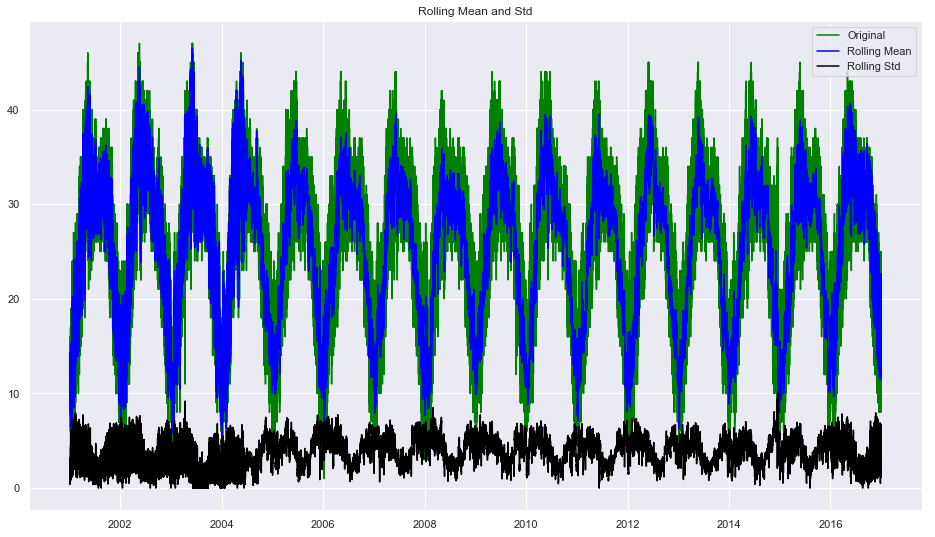

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-6.830511945554582, 1.898995729719106e-09, 64, 76442, {'1%': -3.4304355487769147, '5%': -2.8615778110906995, '10%': -2.5667901255428536}, 314999.5058241563)
df_output: 
 Test Statistic                -6.830512e+00
p-value                        1.898996e-09
#Lags Used                     6.400000e+01
Number of Observations Used    7.644200e+04
dtype: float64
Test Statistic                -6.830512e+00
p-value                        1.898996e-09
#Lags Used                     6.400000e+01
Number of Observations Used    7.644200e+04
Critical Value (1%)           -3.430436e+00
Critical Value (5%)           -2.861578e+00
Critical Value (10%)          -2.566790e+00
dtype: float64


In [110]:
stationarity_check(ts)

### From the above ADF test, p< 0.05 implies that the series does not have a unit root and is stationary and test statistics < critical values of confidence levels, so we reject null hypothesis and the series is stationary.¶

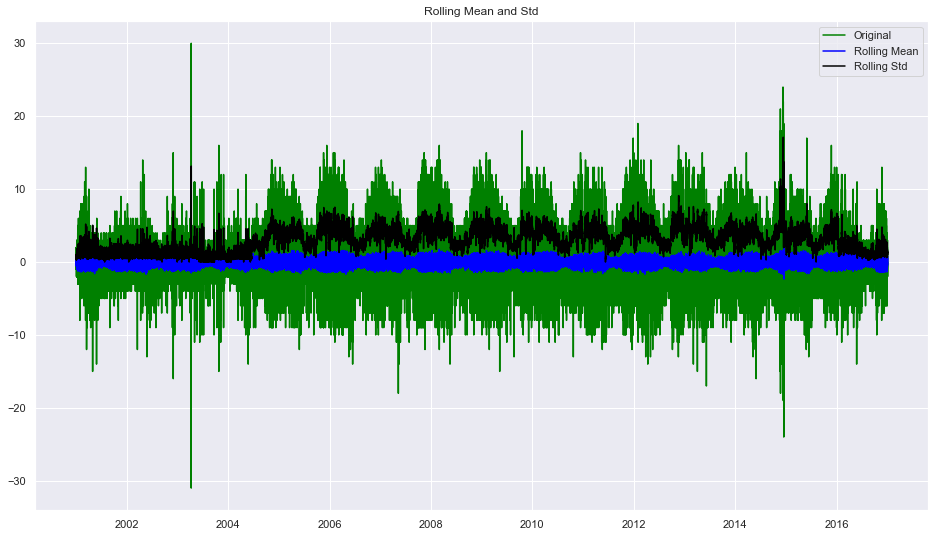

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-38.33428154283788, 0.0, 64, 76441, {'1%': -3.4304355498961, '5%': -2.861577811585353, '10%': -2.566790125806142}, 315038.9034601227)
df_output: 
 Test Statistic                   -38.334282
p-value                            0.000000
#Lags Used                        64.000000
Number of Observations Used    76441.000000
dtype: float64
Test Statistic                   -38.334282
p-value                            0.000000
#Lags Used                        64.000000
Number of Observations Used    76441.000000
Critical Value (1%)               -3.430436
Critical Value (5%)               -2.861578
Critical Value (10%)              -2.566790
dtype: float64


In [111]:
# Apply differencing and power transformation to remove trend, sesonality and noise.

## since there is no exponential trend we are using the series to fit the model

log_series = np.log(ts)

series_diff = ts.diff()
series_diff = series_diff.dropna()

#log_series_diff = log_series.diff()
#log_series_diff = log_series_diff.dropna()

stationarity_check(series_diff)

### From previous week Differencing of data transformation has better performance compared to other transformations

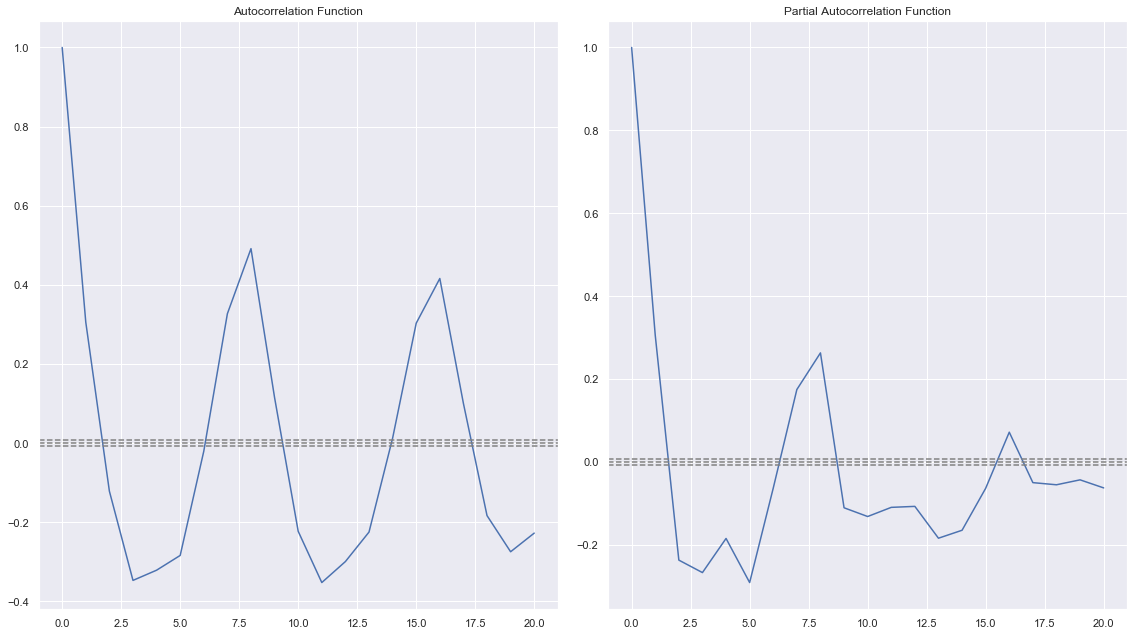

In [112]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(series_diff, nlags=20)
lag_pacf = pacf(series_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(series_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

From the above plots p = 2 and q = 2

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                76506
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -168910.209
Method:                       css-mle   S.D. of innovations              2.201
Date:                Fri, 31 Jul 2020   AIC                         337832.417
Time:                        11:57:45   BIC                         337887.888
Sample:                             1   HQIC                        337849.457
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.648e-05      0.007     -0.002      0.998      -0.013       0.013
ar.L1.D.y      1.3829      0.001   1434.219      0.000       1.381       1.385
ar.L2.D.y     -0.9780      0.00

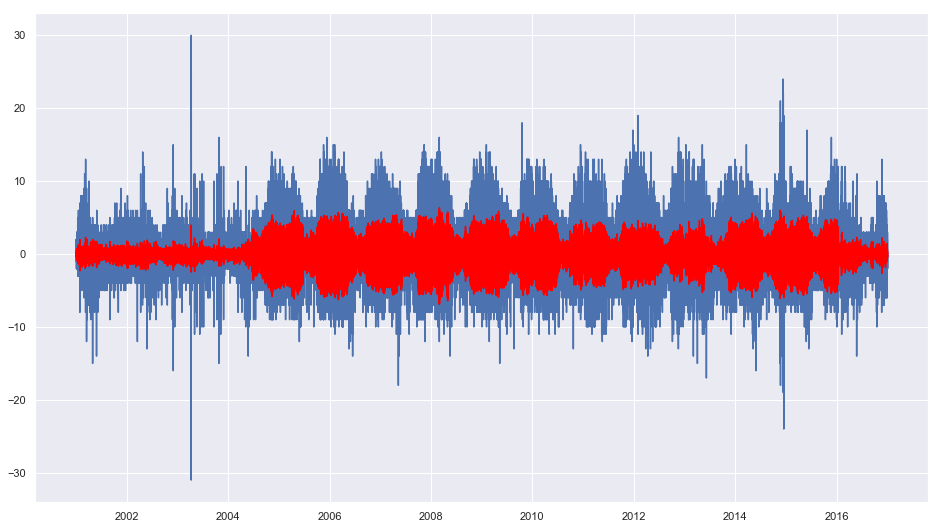

In [113]:
model = ARIMA(ts, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(series_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

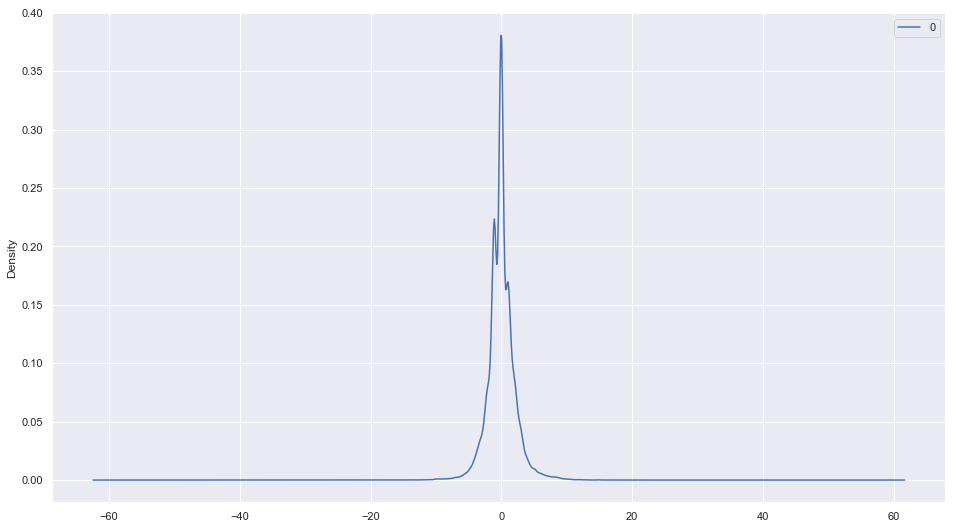

In [103]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()

In [104]:
print(residuals.describe())

                  0
count  61536.000000
mean      -0.000008
std        2.089399
min      -31.436726
25%       -1.078820
50%       -0.049374
75%        0.995548
max       30.641836


### From the above description and chart , mean is close to zero(less error)

In [115]:
pred = pd.Series(results_ARIMA.fittedvalues, copy=True)
pred_sum = pred.cumsum()

In [124]:
pred_log = pd.Series(ts.iloc[0], index=train.index)
pred_log = pred_log.add(pred_sum, fill_value=0)

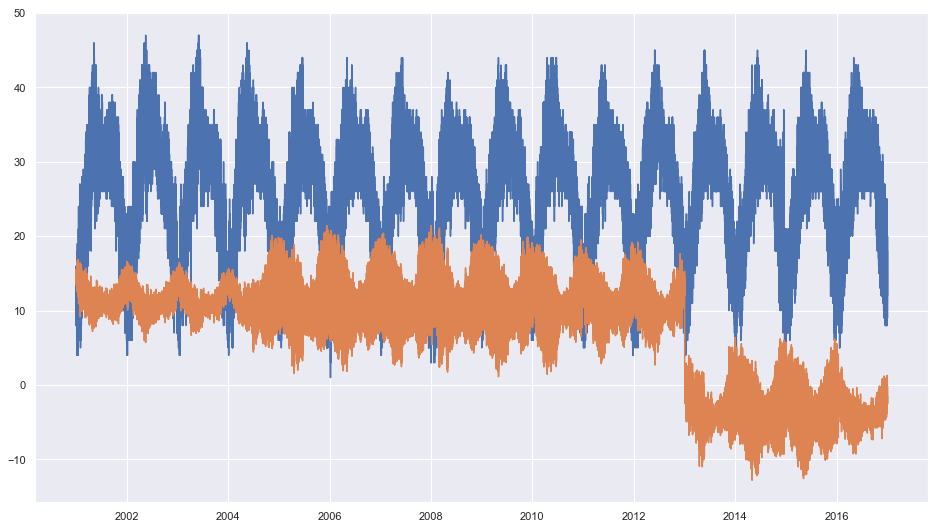

In [118]:
plt.plot(ts)
plt.plot(pred_log)

### Forecast are not accurate because on less features in data. 